In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Sampler, BackendSampler
from qiskit import Aer, QuantumRegister
from qiskit_optimization.algorithms import CplexOptimizer

from os.path import dirname, abspath
import sys
parent_dir = dirname(dirname(abspath(' ')))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from src.optimizer.Quantum_Optimizer_FGSR_b import *
from src.encode.encode_mutual_exclusion import *
from src.bitflip_strategy.local_search_general import *

import warnings
warnings.simplefilter('ignore')

In [2]:
pb_name = '2dc_size128'

In [3]:
refvals = {
    '1dc_size64' : 10,
    '1dc_size128': 16,
    '1dc_size256': 30,
    '2dc_size128': 5,
    '2dc_size256': 7,
    '1tc_size8': 4,
    '1tc_size16': 8,
    '1tc_size32': 12,
    '1tc_size64': 20,
    '1tc_size128': 38,
    '1tc_size256': 63,
    '1et_size64' : 18,
    '1et_size128': 28,
    '1et_size256': 50,
}

In [4]:
fname = parent_dir + f'/instances/MIS/{pb_name}.txt'

with open(fname) as f:
    for i, rows in enumerate(f):
        v = rows.rstrip('\n').split()

        if i == 0:
            N = int(v[2])
            num_constraints = int(v[3])
            A = np.zeros((num_constraints, N), dtype=int)

        else:
            A[i-1, int(v[1])-1] = 1
            A[i-1, int(v[2])-1] = 1

print(f'problem size: {N}')

problem size: 128


In [5]:
target_mdl = QuadraticProgram('MIS problem')

for k in range(N):
    target_mdl.binary_var(f'x({k})')

c_obj = np.ones(N, dtype=int)
target_mdl.maximize(linear=c_obj)

for k in range(num_constraints):
    target_mdl.linear_constraint(linear=A[k], sense='<=', rhs=1)


In [6]:
qubo = QuadraticProgramToQubo().convert(target_mdl)

Q_info = qubo.objective.quadratic.coefficients.copy()
l_diag = qubo.objective.linear
for k in range(N):
    Q_info[k,k] += l_diag[k]
Q = Q_info.tocoo()
Q_data = np.stack([Q.row, Q.col, Q.data], axis=1)

In [7]:
efficient_encode = create_encode()
efficient_encode.set_encode(target_mdl)
num_comb = efficient_encode.n_comb
num_qubits = math.ceil(math.log2(num_comb))
decode = efficient_encode.decode

print(f'number of system qubits: {num_qubits}')

number of system qubits: 30


In [8]:
def objective(x):
    x = decode(x)
    val = x @ Q @ x
    return val

In [9]:
# max number of random flips for each bitstring
n_flips = 10

def search(x):
    x = local_search(x, func=objective, maxiter=n_flips)
    return x

In [10]:
n_reps = 3

q = QuantumRegister(num_qubits, name='q')
sub_qc = QuantumCircuit(q)
qc_params = ParameterVector(name='theta', length=num_qubits*n_reps)

for l in range(n_reps):
    k = 0
    while 2*k < num_qubits-1:
        sub_qc.cz(q[2*k], q[2*k+1])
        k += 1
            
    k = 0
    while 2*k+1 < num_qubits-1:
        sub_qc.cz(q[2*k+1], q[2*k+2])
        k += 1

    for k in range(num_qubits):
        sub_qc.ry(qc_params[l*num_qubits+k], q[k])

    sub_qc.barrier()

In [11]:
shots = 2**10
backend = Aer.get_backend('aer_simulator_matrix_product_state')

sampler = BackendSampler(backend=backend)
sampler.set_options(shots=shots)

print(f'shots = {shots}')

shots = 1024


In [12]:
refval = -refvals[pb_name]

print(f'reference value: {refval:.3f}')

reference value: -5.000


In [13]:
# configure
alpha = 0.4
max_epoch = 1
restart_s = 0.7
restart_std = 0

In [14]:
QuantumSolver = QuantumOptimizer()
QuantumSolver.set_optimizer(num_qubits, sub_qc, sampler)

QuantumSolver.run(
    objective = objective,
    search = search,
    alpha = alpha,
    random_update = True,
    max_epoch = max_epoch,
    restart_s = restart_s,
    restart_std = restart_std,
    refval = refval,
    intermediate_result_display = True
    )

epoch = 0 	 step = 0 	 objval = -3.000 	 cvar = 1069.868   	 s-prob = 0.000e+00
epoch = 0 	 step = 0 	 objval = -5.000 	 cvar = 459.273   	 s-prob = 2.246e-02
epoch = 0 	 step = 1 	 objval = -5.000 	 cvar = 455.785   	 s-prob = 2.832e-02
epoch = 0 	 step = 2 	 objval = -5.000 	 cvar = 431.261   	 s-prob = 3.516e-02
epoch = 0 	 step = 3 	 objval = -5.000 	 cvar = 418.088   	 s-prob = 3.711e-02
epoch = 0 	 step = 4 	 objval = -5.000 	 cvar = 410.185   	 s-prob = 3.906e-02
epoch = 0 	 step = 5 	 objval = -5.000 	 cvar = 348.937   	 s-prob = 5.664e-02
epoch = 0 	 step = 6 	 objval = -5.000 	 cvar = 372.212   	 s-prob = 4.395e-02
epoch = 0 	 step = 7 	 objval = -5.000 	 cvar = 326.298   	 s-prob = 5.566e-02
epoch = 0 	 step = 8 	 objval = -5.000 	 cvar = 319.976   	 s-prob = 6.543e-02
epoch = 0 	 step = 9 	 objval = -5.000 	 cvar = 307.407   	 s-prob = 7.324e-02
epoch = 0 	 step = 10 	 objval = -5.000 	 cvar = 319.354   	 s-prob = 5.957e-02
epoch = 0 	 step = 11 	 objval = -5.000 	 cvar = 3

In [15]:
result = QuantumSolver.elog

L1 = [3*i+1 for i in range(len(result))]
L2 = list(result)
L3 = list(QuantumSolver.plog)
L4 = list(QuantumSolver.log)

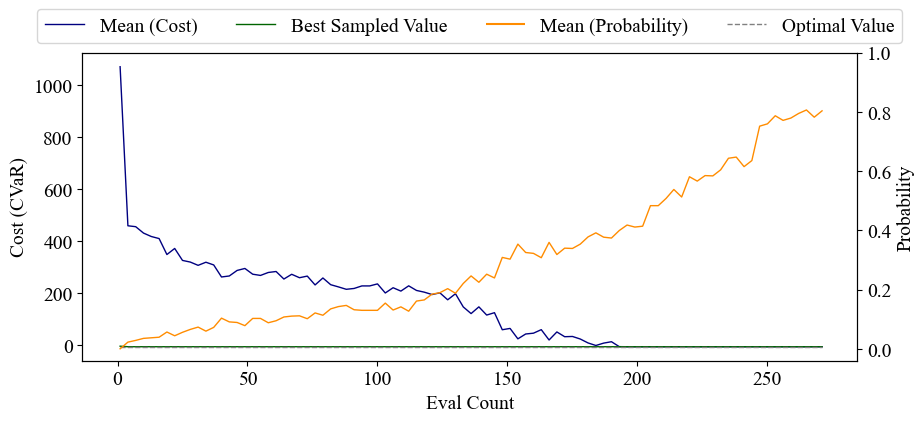

In [16]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 14

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.default'] = 'it'

fig, ax = plt.subplots(figsize=(10, 4))
ax2 = ax.twinx()

ax.plot(L1, L2, color='navy', linewidth=1, label='Mean (Cost)')
ax.plot(L1, L4, color='darkgreen', linewidth=1, label='Best Sampled Value')

ax.set_ylabel('Cost (CVaR)')
ax.set_xlabel('Eval Count')

ax.hlines(refval, xmin=0, xmax=0, color='darkorange', label='Mean (Probability)')
ax.hlines(refval, xmin=1, xmax=L1[-1], color='grey', linestyle='dashed', linewidth=1, label='Optimal Value')
ax.legend(loc='lower center', bbox_to_anchor=(.5, 1.0), ncol=4)

ax2.plot(L1, L3, color='darkorange', linewidth=1)
ax2.set_ylabel('Probability')
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])

plt.show()